In [ ]:
#ALL INSTALLTIONS
!pip install transformers

#BERT based fine tuning adapted and inspired from:Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from http://www.mccormickml.com

In [0]:

import tensorflow as tf
import torch

import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from transformers import BertTokenizer as bertTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

from sklearn.svm import SVC
from sklearn import preprocessing

from transformers import BertForSequenceClassification as bfsc,AdamW,BertConfig


Using TensorFlow backend.


In [0]:
gpuname=""
device=""
y=""
preprocessedTweets=""
ids_of_sentence=[]
ids_of_sentence_words=[]
attention_masks=[]


In [0]:

def initGpus1():
  gpuname=tf.test.gpu_device_name()
  if gpuname=='/device:GPU:0':
    print('Found GPU at :{}'.format(gpuname))
  else:
    gpuname=""
  if torch.cuda.is_available():
    device=torch.device("cuda")
    n_gpu=torch.cuda.device_count()
    print("The device name is %s"%torch.cuda.get_device_name(0))
  else:
    print("No GPU available using only CPU instead")
    device=torch.device("cpu")
  return gpuname,device



In [0]:

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
torch.tensor(2251).flatten()

tensor([2251])

In [0]:
!unzip -P yourpassword -qq '/content/drive/My Drive/GreekData/PredictFile.zip'
!unzip -P yourpassword -qq '/content/drive/My Drive/GreekData/starting_k.zip'
!unzip -P yourpassword -qq '/content/drive/My Drive/GreekData/offenseval2020-test-greek.zip'
!unzip -P yourpassword -qq '/content/drive/My Drive/GreekData/Greek.zip'

In [0]:
ygiven=[]
ypredicted=[]

def convertToInt(val):
    if not val:
        return 0    
    try:
        return np.int64(val)
    except:        
        return np.int64(0)




In [0]:
headers=['id','ypredicted']
greekdataBaseline = pd.read_csv("task_a_baseline.csv", delimiter=',',names=headers)
#,converters={"id":convertToInt}       
greekdataBaseline.iloc[0]                    
print(greekdataBaseline.dtypes)


id             int64
ypredicted    object
dtype: object


In [0]:
pip install emoji --upgrade

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=d7518b80051b831c290c4244e9aa0d2d954b4028aed1e79ec149d91172696f19
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import spacy.cli
spacy.cli.download("el_core_news_md")


✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_md')


In [0]:
#LEMMATIZATION
import string
import spacy
#import el_core_news_sm 
from spacy.tokenizer import Tokenizer
import re
import emoji

nlp =  spacy.load('el_core_news_md')
#Preprocessing # to HASHTAG so that spacy can tokenize it properly
#p=re.compile(r"(#)",re.UNICODE)
#p1=re.compile(r"\.*",re.UNICODE)
##tokenization with NLTK and SPACY DIDNT WORK TOGETHER

In [0]:
stop_words=nlp.Defaults.stop_words

In [0]:

          
def preprocess1(arrt):
    doc=[]
    emojis={}
    #noises = ['@USER','n\'t', '\'s', '\'m',"’"]
    allTokens =[]

    for txt in arrt:
        k=0
        sentVect=[]
        txt1=emoji.demojize(txt)
        x1=nlp(txt1)
        x2=[]
        for t in x1:
            z=str(t)
            if z not in string.punctuation  and t.is_stop==False:
                x2.append(z)
                   
        
        sentence=' '.join((x2))         
        allTokens.append(sentence)      
    return allTokens


In [0]:
headers=['id','tweet']
greekDataTest = pd.read_csv("testset_taska.tsv", delimiter='\t',names=headers,
                                converters={"id":convertToInt})
greekDataTest=greekDataTest[1:]
print(greekDataTest.head())
print(greekDataTest.dtypes)
print(greekDataTest.shape)


     id                                              tweet
1  2707  @USER Θέλω να των δω από εδώ και εμπρός αν δεν...
2  2251  #survivorgr Α Και 60 φορές και με διαφορετικού...
3  9814  Και μου έλεγε η γυναίκα μου το πρωί πάρε την τ...
4  8949                   κατω τα χερια απο τον #κυρανακης
5  6913  @USER μην μας το παιζεις πονοψυχη,κρυφορατσιστ...
id        int64
tweet    object
dtype: object
(1544, 2)


In [0]:
##Use blob
#GET THE DATA FROM THE PANDAS FRAME
def readData1():
  headers=['id','ypredicted']
  greekdataBaseline = pd.read_csv("/content/drive/My Drive/EnglishData/SUBTASKC1/OffensEvalGoldLabels/greek-goldlabels.csv", delimiter=',',names=headers)
  #,converters={"id":convertToInt}       
  greekdataBaseline.id = greekdataBaseline.id.astype(int)
  #greekdataBaseline=greekdataBaseline[1:]
  print(greekdataBaseline.dtypes)
  headers=['id','tweet']
  greekDataTest = pd.read_csv("testset_taska.tsv", delimiter='\t',names=headers,
                                converters={"id":convertToInt})
  #greekDataTest=greekDataTest[1:]
  print(greekDataTest.head())
  print(greekDataTest.dtypes)
  print(greekDataTest.shape)
  result = pd.merge(greekDataTest, greekdataBaseline, on='id', how='inner')
  print(result.head())
  print(result.dtypes)
  print(result.shape)

  #result=
  #result.sort_values(by=['id'], inplace=True)
  print(result.head())
  dfnumpy=result.to_numpy();
  X=dfnumpy[:, 1].reshape(-1, 1)
  y=dfnumpy[:, 2].reshape(-1, 1)
  tid=dfnumpy[:, 0].reshape(-1, 1)
  print(tid)
  arrt=X[:,0]
  allTokens=preprocess1(arrt)
  preprocessedTweets=allTokens
  return preprocessedTweets,y,tid

In [0]:
len(preprocessedTweets)

0

In [0]:
preprocessedTweets,y,tid=readData1()


id             int64
ypredicted    object
dtype: object
     id                                              tweet
0     0                                              tweet
1  2707  @USER Θέλω να των δω από εδώ και εμπρός αν δεν...
2  2251  #survivorgr Α Και 60 φορές και με διαφορετικού...
3  9814  Και μου έλεγε η γυναίκα μου το πρωί πάρε την τ...
4  8949                   κατω τα χερια απο τον #κυρανακης
id        int64
tweet    object
dtype: object
(1545, 2)
     id                                              tweet ypredicted
0  2707  @USER Θέλω να των δω από εδώ και εμπρός αν δεν...        NOT
1  2251  #survivorgr Α Και 60 φορές και με διαφορετικού...        NOT
2  9814  Και μου έλεγε η γυναίκα μου το πρωί πάρε την τ...        NOT
3  8949                   κατω τα χερια απο τον #κυρανακης        NOT
4  6913  @USER μην μας το παιζεις πονοψυχη,κρυφορατσιστ...        NOT
id             int64
tweet         object
ypredicted    object
dtype: object
(1544, 3)
     id                    

In [0]:
from torch.utils.data import Dataset
tokenizer=bertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=True)
class GreekPredictDataset(Dataset):
    def __init__(self,xypredict):
        self.xypredict = xypredict
        self.maxlength=147
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xypredict[0][index]))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_predict_pytorch = torch.tensor(ids_of_sentence_word)
        y_predict_pytorch=torch.tensor(self.xypredict[1][index])
        x_predict_mask_pytorch=torch.tensor(attention_mask)
        tid_predict_pytorch=torch.tensor(self.xypredict[2][index])
        
        return x_predict_pytorch,x_predict_mask_pytorch,y_predict_pytorch,tid_predict_pytorch
       
    def __len__(self):
        return len(self.xypredict[0])
 
 
 
 



In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  yres.append(predictionArgmax.flatten())
  print("predictionArgmax",predictionArgmax)
  print("labelsFlattend",labelsFlattend)
  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)

In [0]:
yres=[]
finalTid=[]
def predictingData(pTweets,ypred,tid):
  ids_of_sentence=[]
  predictedLabels,trueLabels=[],[]
  
  le = preprocessing.LabelEncoder()
  ypredict=le.fit_transform(ypred.flatten())
  map_location=""
  xypredict=[pTweets,ypredict,tid.flatten()]
  
  tdataset = GreekPredictDataset(xypredict)
  tsampler=RandomSampler(tdataset)
  predictdataloader = DataLoader(tdataset, batch_size=32, num_workers=1, shuffle=False,sampler=tsampler)
  print(device.type)
  model=bfsc.from_pretrained('bert-base-multilingual-cased',num_labels=2,output_attentions=False,output_hidden_states=False)
  if device.type=="cpu":
    model.to(device)
    map_location='cpu'
  else:
    model.cuda()
    map_location=lambda storage, loc: storage.cuda()
  params=list(model.named_parameters())
  eval_f1=0
  eval_acc=0
  nb_eval_steps=0
  checkpoint = torch.load('/content/drive/My Drive/GreekData/bertgreek2.pth.tar',map_location=map_location)
  print("Hello")
  model.load_state_dict(checkpoint['state_dict'])
  model.eval()
  i=0
  for batch in predictdataloader:
      print(i)
      i=i+1
      batch = tuple(t.to(device) for t in batch)        
      inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2],"tids":batch[3]}
      
      with torch.no_grad():       
          outputs = model(inputs["input_ids"],token_type_ids=None,attention_mask=inputs["attention_mask"])
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = (inputs["labels"]).to('cpu').numpy()
      predictedLabels.append(logits)
      trueLabels.append(label_ids)
      tidl=(inputs["tids"]).to('cpu').numpy()
      finalTid.append(tidl)
      tmpf1score,tmpaccscore = calculateF1Score(logits, label_ids)
      eval_f1 = eval_f1+tmpf1score
      eval_acc=eval_acc+tmpaccscore
      nb_eval_steps += 1
      
  print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
  print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
  return predictedLabels,trueLabels,finalTid

In [ ]:
gpuname,device=initGpus1()  
preprocessedTweets,y,tid=readData1()


In [0]:
device

device(type='cpu')

In [0]:
predictedLabels,trueLabels,finalTid=predictingData(preprocessedTweets,y,tid)


cpu



Hello
0
predictionArgmax [1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0]
labelsFlattend [1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0]
1
predictionArgmax [1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1]
labelsFlattend [1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1]
2
predictionArgmax [0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0]
labelsFlattend [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0]
3
predictionArgmax [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
labelsFlattend [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
4
predictionArgmax [0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1]
labelsFlattend [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1]
5
predictionArgmax [0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0]
labelsFlattend [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 

In [0]:
yans=[yres[i].flatten().tolist() for i in range(len(yres))]
ytrue=[trueLabels[i].flatten().tolist() for i in range(len(trueLabels))]
ytid=[finalTid[i].flatten().tolist() for i in range(len(finalTid))]

In [0]:
from itertools import chain

yans=list(chain.from_iterable(yans))

ytrue=list(chain.from_iterable(ytrue))

ytid=list(chain.from_iterable(ytid))

In [0]:
set(yans)

In [0]:
yans1=["NOT" if yans[i]==0 else "OFF" for i in range(len(yans))]
ytrue1=["NOT" if ytrue[i]==0 else "OFF" for i in range(len(ytrue))]


In [0]:
2707 in ytid

In [0]:
print(yans1.count("OFF"))
print(yans1.count("NOT"))

432
1112


In [0]:
print(ytrue1.count("OFF"))
print(ytrue1.count("NOT"))

242
1302


In [0]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(ytrue1, yans1, labels=['OFF', 'NOT'])
print(cnf)

[[ 231   11]
 [ 201 1101]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


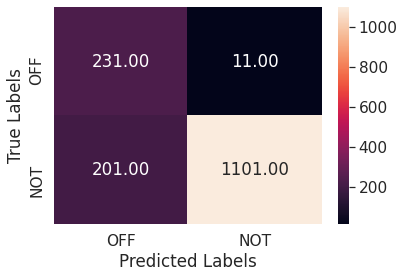

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(cnf,['OFF', 'NOT'], ['OFF', 'NOT'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='.2f') # font size
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

In [0]:
#z={'tweet':sentence_predict[],'subtask_a':y_predict}
#print(len(z))
C = {'id': ytid,
        'predicted': yans1,
     'given':ytrue1
    }
df = pd.DataFrame(C)
print (df[df['id'] == 2707] )

export_csv = df.to_csv ('/content/drive/My Drive/GreekData/GreekAnswerSubtaska.csv', index = None, header=True)

